# Implement your own Riemannian Geometry

Lead author: Nina Miolane.

Geomstats provides several Riemannian manifolds in its `geometry` folder. Yet, the manifold that you are interested in might not be available there.

This notebook shows how to use Riemannian geometry on any manifold defined by an immersion into a Euclidean space, such as high-dimensional surfaces immersed in a Euclidean space. 

Specifically, we focus on the case of an embedded manifold $M$ that can be defined by a map 
$f: M \rightarrow \mathbb{R}^n$ 
called the immersion, whose differential $df_x$ is injective for all $x \in M$.

This immersion allows to define the pull-back metric $g$ on $M$, as:

$$g : T_xM \times T_x M \rightarrow \mathbb{R}\\
u, v \rightarrow <df_x.u, df_x.v>$$

where $<,>$ represents the Euclidean inner-product of the embedding space. 

The pull-back metric gives a structure of Riemannian manifold to $M$. In particular, we can compute the Riemannian exp and log maps, the Riemannian distance, the Riemannian parallel transport, etc.

This notion illustrates the computation of the pull-back metric, using the class `PullbackMetric` from geomstats, on two embedded manifolds:

- the 2-sphere $S^2$ embedded in $\mathbb{R}^3$,

- a surface defined by: $x, y \rightarrow z = x^2 + y^2$ embedded in $\mathbb{R}^3$.

In [1]:
import time
import matplotlib.pyplot as plt

import geomstats.visualization as viz

INFO: Using pytorch backend


In [2]:
import geomstats.backend as gs

We import the main structures used in this notebook: the `ImmersedSet` and the `PullbackMetric`:

In [3]:
from geomstats.geometry.base import ImmersedSet
from geomstats.geometry.pullback_metric import PullbackMetric

## Immersed manifolds: the example of the 2-sphere

We first consider the simple example of the 2-sphere. We define the immersion of the 2-sphere $S^2$ into the Euclidean space $\mathbb{R}^3$ as follows:
$$f : S^2 \rightarrow \mathbb{R}^3\\
(\theta, \phi) \rightarrow (\cos\phi.\sin\theta, \sin\phi.\sin\theta, \cos\theta)$$

In [4]:
from geomstats.geometry.euclidean import Euclidean


class SphereIntrinsic(ImmersedSet):
    def __init__(self, equip=True):
        super().__init__(dim=2, equip=equip)

    def immersion(self, point):
        theta = point[..., 0]
        phi = point[..., 1]
        return gs.stack(
            [
                gs.cos(phi) * gs.sin(theta),
                gs.sin(phi) * gs.sin(theta),
                gs.cos(theta),
            ],
            axis=-1,
        )

    def _define_embedding_space(self):
        return Euclidean(dim=self.dim + 1)

For the purpose of visualizing the results in the embedding space $\mathbb{R}^{3}$, we will need the jacobian of the immersion. Notice that `ImmersedSet` already takes care of it if we want to rely on automatic differentiation.

We use the `PullbackMetric` structure to define the Riemannian metric on $S^2$ from the immersion. 

Note that the Riemannian metric on the sphere is already implemented in Geomstats using closed forms with the class `Hypersphere`. However, this notebook showcases how we can recover the computations of Riemanian geometry by only relying on the immersion.

In [5]:
sphere = SphereIntrinsic(equip=False)

sphere.equip_with_metric(PullbackMetric)

Now, we can access the methods from any Riemannian metric, i.e. the Riemannian exp and log maps, the parallel transport, etc.

We first show the computation of the Riemannian exp map of a tangent vector at a point.

In [6]:
point_a = gs.array([gs.pi / 2.0, -gs.pi / 2.0])
tangent_vec = gs.array([0.0, gs.pi / 3.0])

end_point = sphere.metric.exp(tangent_vec=tangent_vec, base_point=point_a)
print(end_point)

tensor([ 1.5708, -0.5236])


And visualize the result of the Riemannian exp map in the embedding space $\mathbb{R}^3$:

<IPython.core.display.Javascript object>


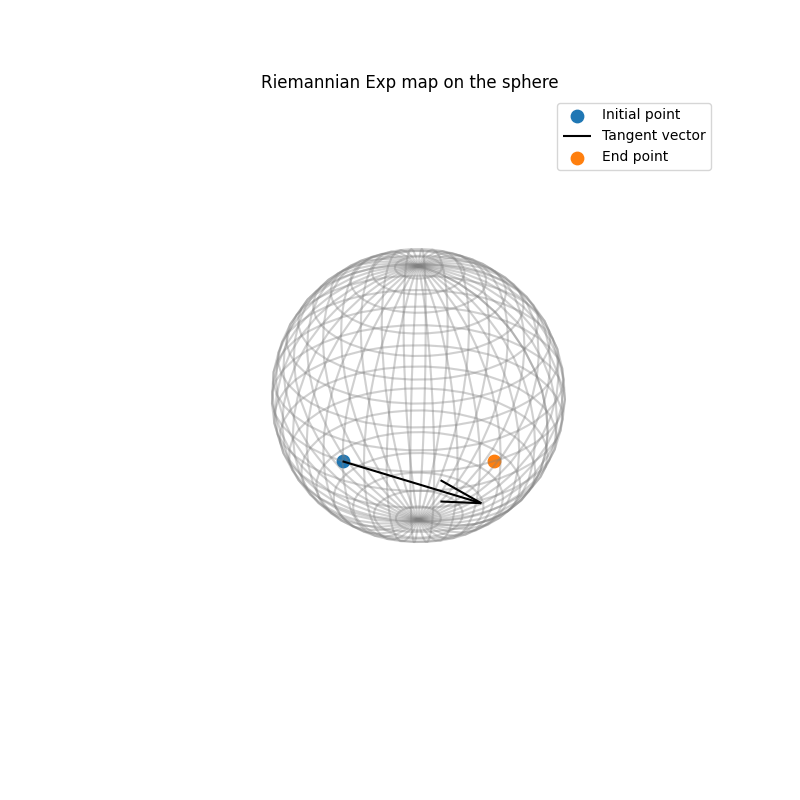

/user/lgomespe/home/miniconda3/envs/geomstats39/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
%matplotlib notebook

# We immerse the points and the tangent vector in R^3

immersed_point_a = sphere.immersion(point_a)
immersed_tangent_vec = sphere.tangent_immersion(tangent_vec, point_a)
immersed_end_point = sphere.immersion(end_point)

# We plot our results

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

viz.plot(immersed_point_a, ax=ax, space="S2", label="Initial point", s=80)

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec)
arrow.draw(ax, color="black", label="Tangent vector")

viz.plot(immersed_end_point, ax=ax, space="S2", label="End point", s=80)

ax.set_title("Riemannian Exp map on the sphere")
ax.legend()
ax.grid(False)
plt.axis("off");

Next, we show the computation of the parallel transport on the sphere. Note that `step`, `n_steps`, `tol` and `alpha` are integration parameters that control the efficiency-accuracy tradeoff of the computation.

In [8]:
point_a = gs.array([gs.pi / 2.0, -gs.pi / 2.0])
tangent_vec = gs.array([0.0, gs.pi / 3.0])
tangent_vec_to_transport = gs.array([gs.pi / 4.0, gs.pi / 3.0])

time_start = time.perf_counter()

sphere.metric.exp_solver.integrator.step = "euler"
sphere.metric.exp_solver.integrator.n_steps = 1
sphere.metric.log_solver.optimizer.tol = 1e-6

parallel_transport = sphere.metric.ladder_parallel_transport(
    tangent_vec=tangent_vec_to_transport,
    direction=tangent_vec,
    base_point=point_a,
    alpha=1,
)

time_elapsed = time.perf_counter() - time_start
print(f"Computing time for parallel transport: {time_elapsed:5.2f} secs")

display(parallel_transport)

transported_tangent_vec = parallel_transport["transported_tangent_vec"]
end_point = parallel_transport["end_point"]

Computing time for parallel transport:  3.96 secs


{'transported_tangent_vec': tensor([0.7854, 1.0472]),
 'end_point': tensor([ 1.5708, -0.5236]),
 'trajectory': [[]]}

We visualize the result of the parallel transport in the embedding space $\mathbb{R}^3$:

is_tangent =  tensor(True)


<IPython.core.display.Javascript object>


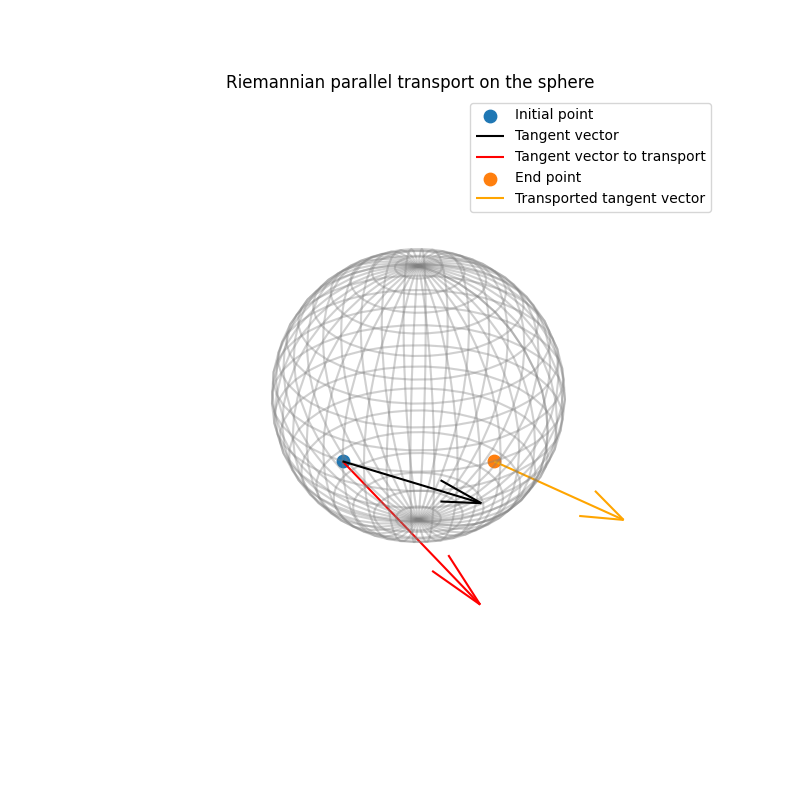

In [9]:
%matplotlib notebook


# We first immerse the points and tangent vectors into the embedding space R^3

immersed_point_a = sphere.immersion(point_a)
immersed_end_point = sphere.immersion(end_point)

immersed_tangent_vec = sphere.tangent_immersion(tangent_vec, point_a)
immersed_tangent_vec_to_transport = sphere.tangent_immersion(tangent_vec_to_transport, point_a)
immersed_transported_tangent_vec = sphere.tangent_immersion(transported_tangent_vec, end_point)

# We verify manually that the immersed tangent vector is actually tangent to the sphere
# as the plot can be sometimes misleading. We use the method of the Hypersphere class.

from geomstats.geometry.hypersphere import Hypersphere

sphere = Hypersphere(dim=2)
is_tangent = sphere.is_tangent(
    immersed_transported_tangent_vec, base_point=immersed_end_point
)
print("is_tangent = ", is_tangent)

# We plot the results

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")

viz.plot(immersed_point_a, ax=ax, space="S2", label="Initial point", s=80)

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec)
arrow.draw(ax, color="black", label="Tangent vector")

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec_to_transport)
arrow.draw(ax, color="red", label="Tangent vector to transport")

viz.plot(immersed_end_point, ax=ax, space="S2", label="End point", s=80)

arrow = viz.Arrow3D(immersed_end_point, vector=immersed_transported_tangent_vec)
arrow.draw(ax, color="orange", label="Transported tangent vector")

ax.set_title("Riemannian parallel transport on the sphere")
ax.legend()
ax.grid(False)
plt.axis("off");

## Immersed manifolds: the example of a surface defined by its graph

We consider the example of a 2D surface immersed in $\mathbb{R}^3$. The surface is defined by its graph:

$$ x, y \rightarrow z = x^2 + y^2$$

which leads to the following immersion into $\mathbb{R}^3$:
$$f : S^2 \rightarrow \mathbb{R}^3\\
(x, y) \rightarrow (x, y, x^2 + y^2)$$

We first implement the graph and the immersion:

In [10]:
class Surface(ImmersedSet):
    
    def __init__(self, equip=True):
        super().__init__(dim=2, equip=equip)
    
    def _define_embedding_space(self):
        return Euclidean(dim=self.dim + 1)
    
    def graph(self, x, y):
        return x**2 + y**2
 
    def immersion(self, point):
        x = point[..., 0]
        y = point[..., 1]
        return gs.transpose(gs.array([x, y, self.graph(x, y)]))

In [11]:
surface = Surface(equip=False)

For the purpose of visualizing the results in the embedding space  ℝ3 , we will need the jacobian of the immersion, which we compute here. Notice that `ImmersedSet` already takes care of it if we want to rely on automatic differentiation.

We also add a utility function to visualization the surface in 3D:

<IPython.core.display.Javascript object>


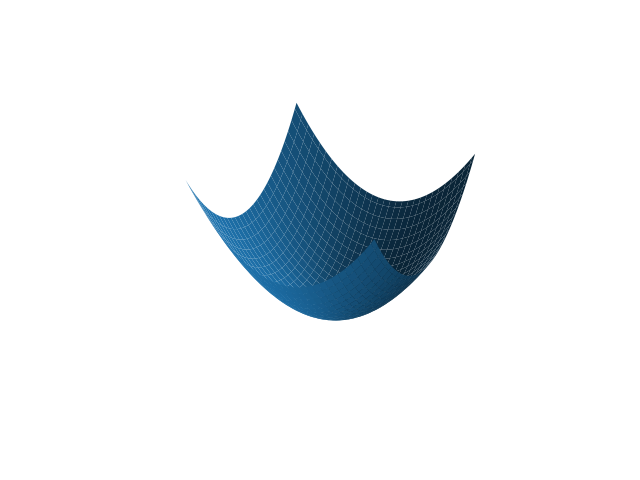

In [12]:
%matplotlib notebook


def plot_surface(surface, alpha=1.0, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

    x = y = gs.arange(-3.0, 3.0, 0.1)
    X, Y = gs.meshgrid(x, y)
    zs = gs.array(surface.graph(gs.flatten(X), gs.flatten(Y)))
    Z = gs.reshape(zs, X.shape)

    ax.plot_surface(gs.to_numpy(X), gs.to_numpy(Y), gs.to_numpy(Z), alpha=alpha)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Zm")
    plt.show()
    return ax


ax = plot_surface(surface)
ax.grid(False)
plt.axis("off");

We use the `PullbackMetric` structure to define the Riemannian metric on the surface from the immersion. 

In [13]:
surface.equip_with_metric(PullbackMetric)

Now, we can access the methods from any Riemannian metric, i.e. the Riemannian exp and log maps, the parallel transport, etc.

We show the computation of the Riemannian exp map:

In [14]:
point_a = gs.array([-2.0, -2.0])
tangent_vec = gs.array([0.0, 1.0])

end_point = surface.metric.exp(tangent_vec=tangent_vec, base_point=point_a)
print(end_point)

tensor([-1.8233, -0.8588])


And visualize the result:

<IPython.core.display.Javascript object>


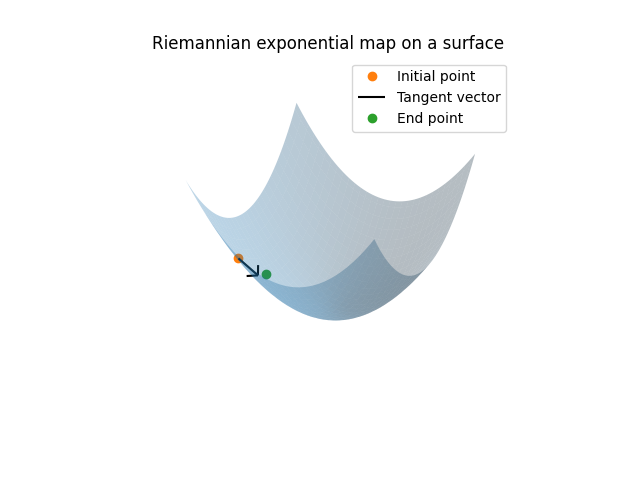

In [15]:
%matplotlib notebook

# We first immerse the points and tangent vector into the embedding space R^3

immersed_point_a = surface.immersion(point_a)
immersed_tangent_vec = surface.tangent_immersion(tangent_vec, point_a)
immersed_end_point = surface.immersion(end_point)

two_points = gs.vstack([immersed_point_a, immersed_end_point])

# We plot the results

ax = plot_surface(surface, alpha=0.3)

ax.plot(
    immersed_point_a[0],
    immersed_point_a[1],
    immersed_point_a[2],
    label="Initial point",
    marker="o",
    linestyle="None",
)

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec)
arrow.draw(ax, color="black", label="Tangent vector")

ax.plot(
    immersed_end_point[0],
    immersed_end_point[1],
    immersed_end_point[2],
    label="End point",
    marker="o",
    linestyle="None",
)

ax.set_title("Riemannian exponential map on a surface")
ax.legend()
ax.grid(False)
plt.axis("off");

Next, we show the computation of the parallel transport on the surface. Again, note that `step`, `n_steps`, `tol` and `alpha` are integration parameters that control the efficiency-accuracy tradeoff of the computation.

In [16]:
point_a = gs.array([-2.0, -2.0])
tangent_vec = gs.array([0.0, 1.0])
tangent_vec_to_transport = gs.array([-0.6, 0.6])

time_start = time.perf_counter()

surface.metric.exp_solver.integrator.step = "rk4"
surface.metric.exp_solver.integrator.n_steps = 1
surface.metric.log_solver.optimizer.tol = 1e-14

parallel_transport = surface.metric.ladder_parallel_transport(
    tangent_vec=tangent_vec_to_transport,
    direction=tangent_vec,
    base_point=point_a,
    alpha=2,
)
time_elapsed = time.perf_counter() - time_start
print(f"Computing time for parallel transport: {time_elapsed:5.2f} secs")

display(parallel_transport)

transported_tangent_vec = parallel_transport["transported_tangent_vec"]
end_point = parallel_transport["end_point"]

Computing time for parallel transport:  3.70 secs


{'transported_tangent_vec': tensor([-0.3782,  0.7543]),
 'end_point': tensor([-1.8233, -0.8588]),
 'trajectory': [[]]}

We visualize the result of the parallel transport.

<IPython.core.display.Javascript object>


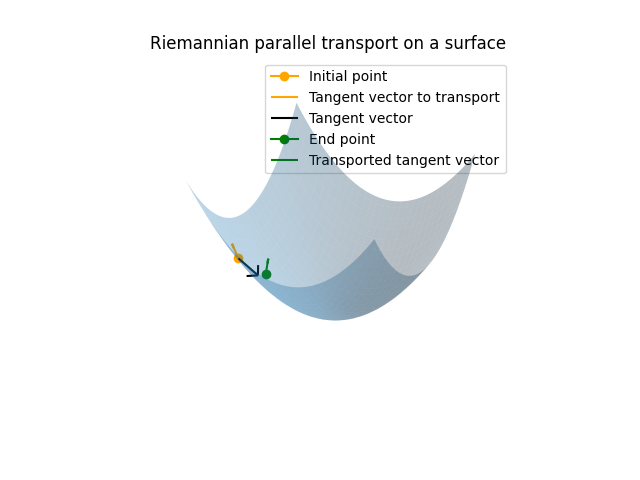

In [17]:
%matplotlib notebook

# We first immerse the points and tangent vectors into the embedding space R^3

immersed_point_a = surface.immersion(point_a)
immersed_tangent_vec = surface.tangent_immersion(tangent_vec, point_a)
immersed_tangent_vec_to_transport = surface.tangent_immersion(tangent_vec_to_transport, point_a)
immersed_end_point = surface.immersion(end_point)
immersed_transported_tangent_vec = surface.tangent_immersion(transported_tangent_vec, end_point)

# We plot the results

ax = plot_surface(surface, alpha=0.3)

ax.plot(
    immersed_point_a[0],
    immersed_point_a[1],
    immersed_point_a[2],
    label="Initial point",
    marker="o",
    color="orange",
)

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec_to_transport)
arrow.draw(ax, color="orange", label="Tangent vector to transport")

arrow = viz.Arrow3D(immersed_point_a, vector=immersed_tangent_vec)
arrow.draw(ax, color="black", label="Tangent vector")

ax.plot(
    immersed_end_point[0],
    immersed_end_point[1],
    immersed_end_point[2],
    label="End point",
    marker="o",
    color="green",
)


arrow = viz.Arrow3D(immersed_end_point, vector=immersed_transported_tangent_vec)
arrow.draw(ax, color="green", label="Transported tangent vector")

ax.set_title("Riemannian parallel transport on a surface")
ax.legend()
ax.grid(False)
plt.axis("off");